In [540]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity

########################################################################
# 2.1. Basic Shor Encoding (Classical Implementation: 2 CNOTs, H, 6 CNOTs)
########################################################################

reg, clas_reg = None, None

def shor_encode_3(qc, qubits):

    # (1) Triple repetition for Z-error protection
    qc.cx(qubits[0], qubits[3])
    qc.cx(qubits[0], qubits[6])

def shor_encode_9(qc, qubits):
    """
    Encode qubits[0] into a block of 9 physical qubits.
    Steps (classical perspective):
     - 2 CNOTs for triple repetition
     - Hadamards
     - 6 CNOTs for the second repetition
    """
    # (2) For each of the 3 qubits above, do H + 2 CNOTs => total 3 * (1 H + 2 CNOTs) = 3 H + 6 CNOT
    # block 1: qubits[0] -> qubits[3], qubits[4]
    qc.h(qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.cx(qubits[0], qubits[2])
    
    # block 2: qubits[1] -> qubits[5], qubits[6]
    qc.h(qubits[3])
    qc.cx(qubits[3], qubits[4])
    qc.cx(qubits[3], qubits[5])
    
    # block 3: qubits[2] -> qubits[7], qubits[8]
    qc.h(qubits[6])
    qc.cx(qubits[6], qubits[7])
    qc.cx(qubits[6], qubits[8])
    return qc
    


########################################################################
# 2.2. Partial Decode to 3 "Logical" Qubits 
#     (Remove the H + 2*CNOT part only)
########################################################################

def shor_partial_decode(qc, qubits_9):
    """
    Invert the second-layer encoding on each triple block:
     - 2 CNOT + H
    Leaves us with 3 qubits that are still triple-repetition for Z-protection.
    We'll place them in qubits_9[0], qubits_9[1], qubits_9[2].
    The others become disentangled (ideally).
    """
    # block 1: [0,3,4]
    qc.cx(qubits_9[0], qubits_9[2])
    qc.cx(qubits_9[0], qubits_9[1])
    # qc.h(qubits_9[0])
    
    # block 2: [1,5,6]
    qc.cx(qubits_9[3], qubits_9[5])
    qc.cx(qubits_9[3], qubits_9[4])
    # qc.h(qubits_9[3])
    
    # block 3: [2,7,8]
    qc.cx(qubits_9[6], qubits_9[8])
    qc.cx(qubits_9[6], qubits_9[7])
    # qc.h(qubits_9[6])
    return qc


########################################################################
# 2.4. Full Decode from 9 qubits to 1 
#      (the triple repetition part => 2 CNOT)
########################################################################

def shor_final_decode(qc, qubits_9):
    """
    Remove the triple repetition for Z error protection.
    We do the inverse of '2 CNOTs' from the first step of encoding.
    After that, qubit[0] is the single recovered logical qubit.
    """
    qc.h(0)
    qc.h(3)
    qc.h(6)

    qc.cx(qubits_9[0], qubits_9[3])
    qc.cx(qubits_9[0], qubits_9[6])
    return qc

########################################################################
# 2.5. Utility: Toffoli among 3 qubits
########################################################################

def apply_3_toffoli_gates(qc, qubits_9):
    """
    Apply 3 distinct Toffoli gates among these 3 qubits in some pattern.
    For example:
      Toffoli(0,1 -> 2)
      Toffoli(0,2 -> 1)
      Toffoli(1,2 -> 0)
    """
    # Gate 1
    qc.ccx(qubits_9[2], qubits_9[1], qubits_9[0])
    # Gate 2
    qc.ccx(qubits_9[5], qubits_9[4], qubits_9[3])
    # Gate 3
    qc.ccx(qubits_9[8], qubits_9[7], qubits_9[6])
    return qc

def apply_one_toffoli_among_3(qc, qubits_3):
    """
    Apply one more Toffoli gate that uses the 3 qubits.
    Let's do a standard Toffoli(0,1->2).
    """
    qc.ccx(qubits_3[6], qubits_3[3], qubits_3[0])
    return qc

########################################################################
# 2.6. Full "Classical" Shor Code Circuit with 
#      - Encode (9 qubits total)
#      - Error in the middle
#      - Partial Decode => 3 logical qubits
#      - 3 Toffoli gates among them
#      - 1 more Toffoli among them
#      - Re-Encode => 9 qubits
#      - Final Decode => 1 qubit
########################################################################

def build_shor_toffoli_circuit(error_in_middle=False):
    global reg, clas_reg
    """
    Build a circuit that:
      1) Prepares a test state on qubit 0
      2) Fully encodes into 9 qubits
      3) (Optionally) applies an error or noise in the middle
      4) Partially decodes to get 3 logical qubits
      5) Apply 3 Toffoli gates among these 3 logical qubits
      6) Apply 1 more Toffoli among the same 3
      7) Re-encode them to get back 9 qubits
      8) Final decode to 1 qubit
      9) Measure

    We will test how well this pipeline corrects errors.
    """
    reg = QuantumRegister(9)
    clas_reg = ClassicalRegister(1)
    qc = QuantumCircuit(reg, clas_reg)
    
    # 1) Prepare an example single-qubit state (|0> + i|1>)/sqrt(2)
    
    

    qc.h(0)
    qc.rz(np.pi/4, 0)
    qc.h(0)
    # qc.s(0)

    shor_encode_3(qc, range(9))

        # 2) Full encode to 9 qubits
    shor_encode_9(qc, range(9))

    
    # 3) An optional place to insert a single-qubit error 
    #    or rely on the noise model for gate errors.
    if error_in_middle:

        # qc.z(0)
        # qc.z(1)
        # Example: X error on qubit 4
        
        # qc.x(0)
        # qc.x(1)
        # qc.x(2)
        # qc.x(3)
        # qc.x(4)
        # qc.x(5)
        # qc.x(6)
        # qc.x(7)
        # qc.x(8)

        qc.z(0)
        qc.z(4)
        # qc.z(5)

        pass
    
    # 4) Partial decode => 3 logical qubits are [0,1,2]
    shor_partial_decode(qc, range(9))
    
    # 5) 3 Toffoli gates among qubits [0,1,2]
    apply_3_toffoli_gates(qc, range(9))

    # 8) Final decode => single qubit is qubit 0
    shor_final_decode(qc, range(9))
    
    # 6) 1 more Toffoli among these 3
    apply_one_toffoli_among_3(qc, range(9))

    simulated_state = Statevector.from_instruction(qc)

    # qc.x(1)
    # qc.x(2)
    # qc.h(4)
    # qc.h(5)
    # qc.h(7)
    # qc.h(8)
    
    # 9) Measure
    for num, i in enumerate([0]):
    # for num, i in enumerate([0, 3, 6]):
    # for num, i in enumerate([0, 1, 2]):
        qc.measure(i, num)
    
    return qc, simulated_state

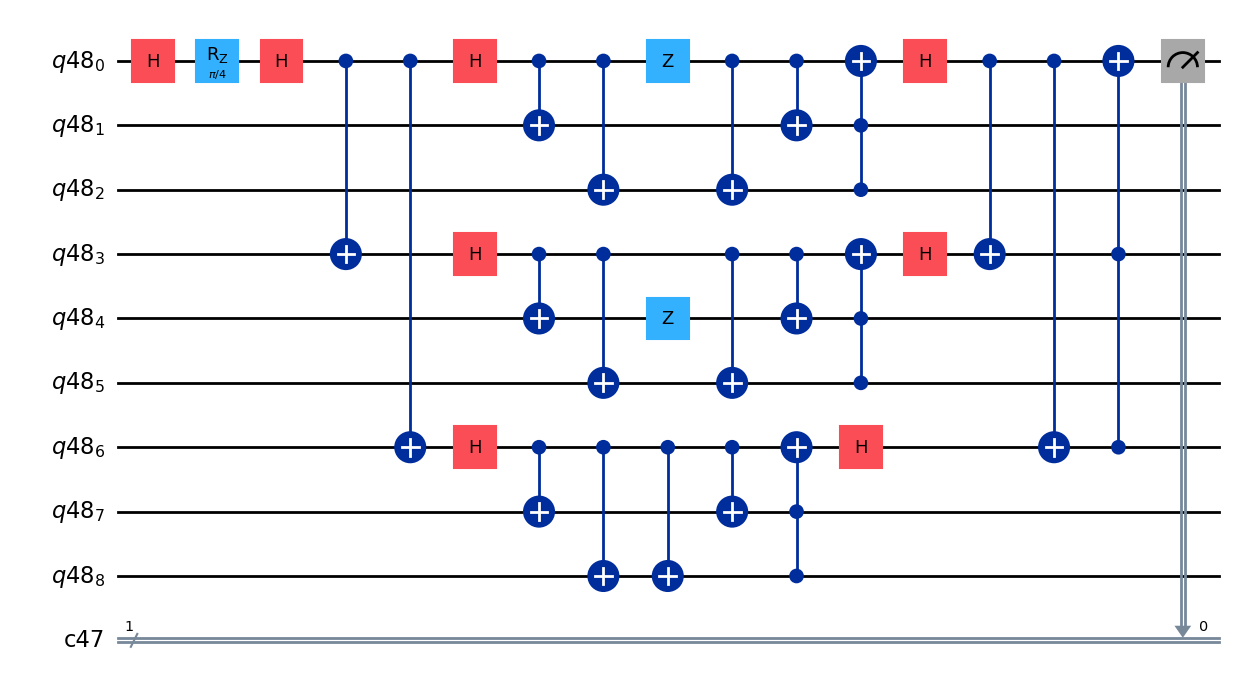

In [541]:
_, target_state = build_shor_toffoli_circuit(error_in_middle=False)
circuit, simulated_state = build_shor_toffoli_circuit(error_in_middle=True)

circuit.draw('mpl', style={'name': 'iqx'})

In [542]:
from qiskit.quantum_info import partial_trace

# Calculate fidelity
traced_over_qubits = [ circuit.qubits.index(qubit) for qubit in reg[[1, 2, 3, 4, 5, 6, 7, 8]]]
target_state_matr = partial_trace(target_state, traced_over_qubits)
simulated_state_matr = partial_trace(simulated_state, traced_over_qubits)

# target_state_matr = target_state_matr.data
# target_state_matr.shape

fidelity = state_fidelity(target_state_matr, simulated_state_matr)
# fidelity = state_fidelity(target_state, simulated_state)
print("State Fidelity:", fidelity)

State Fidelity: 2.6932247207168216e-16


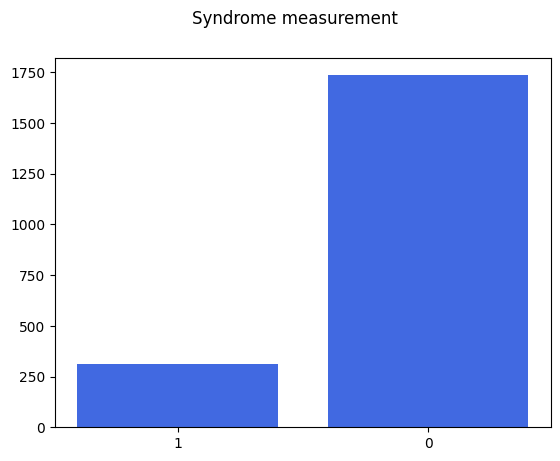

{'1': 313, '0': 1735}


In [537]:
backend = QasmSimulator()
shots = 2048

results = backend.run(circuit, shots=shots).result()
answer = results.get_counts()

keys = list(answer.keys())

plt.suptitle("Syndrome measurement")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)